In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import get_file
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

In [ ]:
path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')

In [ ]:
df = pd.read_csv(path, header=None)
df.head()
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

print(df.shape)

df.drop_duplicates(keep='first', inplace = True)
df.dropna(inplace=True,axis=1) 

(494021, 42)


In [ ]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')



df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004293,0.042595,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
1,-0.10785,-0.004261,-0.039036,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
2,-0.10785,-0.004263,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
3,-0.10785,-0.004272,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
4,-0.10785,-0.004273,-0.013613,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0


In [ ]:
x_columns = df.columns.drop('outcome')
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values
df.groupby('outcome')['outcome'].count()

outcome
back.                 968
buffer_overflow.       30
ftp_write.              8
guess_passwd.          53
imap.                  12
ipsweep.              651
land.                  19
loadmodule.             9
multihop.               7
neptune.            51820
nmap.                 158
normal.             87832
perl.                   3
phf.                    4
pod.                  206
portsweep.            416
rootkit.               10
satan.                906
smurf.                641
spy.                    2
teardrop.             918
warezclient.          893
warezmaster.           20
Name: outcome, dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}

In [ ]:
RF_model = RandomForestClassifier(**parameters)

In [ ]:
RF_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=10, n_estimators=50)

In [ ]:
RF_predictions = RF_model.predict(x_test)
score = accuracy_score(y_test ,RF_predictions)
print(score)

0.9836527234013325


In [ ]:
RF_model.estimators_

[DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                        min_samples_split=10, random_state=1675654675),
 DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                        min_samples_split=10, random_state=1907015790),
 DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                        min_samples_split=10, random_state=1672728201),
 DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                        min_samples_split=10, random_state=1484147984),
 DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                        min_samples_split=10, random_state=991242737),
 DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                        min_samples_split=10, random_state=909555576),
 DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=3,
                        

In [ ]:
for i in range(len(RF_model.estimators_)):
  print(tree.export_text(RF_model.estimators_[i]))

|--- feature_30 <= 1.10
|   |--- feature_5 <= 0.28
|   |   |--- feature_14 <= 0.00
|   |   |   |--- feature_3 <= 2.00
|   |   |   |   |--- feature_106 <= 0.50
|   |   |   |   |   |--- feature_14 <= -0.19
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_14 >  -0.19
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_106 >  0.50
|   |   |   |   |   |--- feature_36 <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_36 >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- feature_3 >  2.00
|   |   |   |   |--- feature_15 <= -0.11
|   |   |   |   |   |--- feature_50 <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_50 >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_15 >  -0.11
|   |   |   |   |   |--- feature_26 <= -0.32
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_26 >  -0.32
|   |   |   |   |   |   |--- class: 0
|   |   |--- feature_14

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), RF_predictions.argmax(axis = 1))

Text(159.0, 0.5, 'Truth')

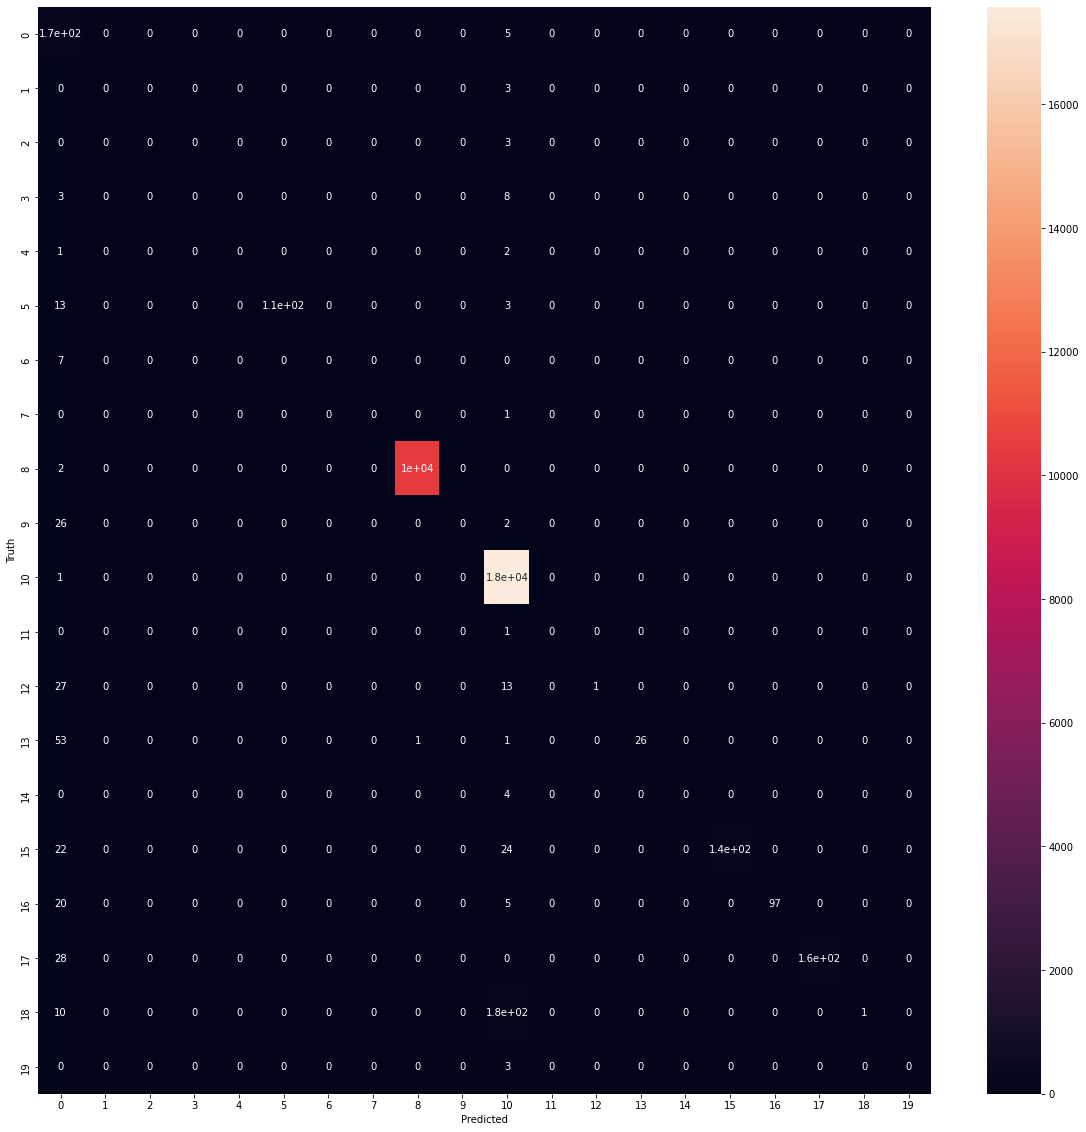

In [ ]:
import seaborn as sn
plt.figure(figsize=(20,20))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')